In [1]:
import torch
from torch import nn # nn contains all building blocks of neural networks
import matplotlib.pyplot as plt

torch.__version__

'2.5.0.dev20240809'

In [2]:
# Check if MPS is available
print(torch.backends.mps.is_available())

# Check if MPS can be used
print(torch.backends.mps.is_built())

True
True


In [3]:
# Define the MPS device
device = torch.device("mps")
# 항상 모델 코드를 짜고 난 후에 model = 내가정의한모델().to(device) 이렇게 추가해야 GPU 위에서 돌아가게 할 수 있다.
# Pytorch는 input data와 model이 같은 device 위에 올려져야하기 때문에 inputs, labels = inputs.to(device), labels.to(device) 이렇게도 해줘야한다. 

In [4]:
w = 0.7
b = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)  # Must unsqueeze and add an extra dimension for later on
y = w*X + b

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [5]:
# Split data into training / test set
train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

## Visualizing Data

In [6]:
def plot(train_data = X_train,
         train_label = y_train,
         test_data = X_test,
         test_label = y_test,
         prediction = None):
    
    plt.figure(figsize = (10,7))
    plt.scatter(train_data, train_label, c = 'b', s=4, label = "training data")
    plt.scatter(test_data, test_label, c = 'r', s=4, label = "test data")

    if prediction is not None:
        plt.scatter(test_data, prediction, c='g', s=4, label="predictions")

    # Show the legend
    plt.legend(prop = {"size": 14});

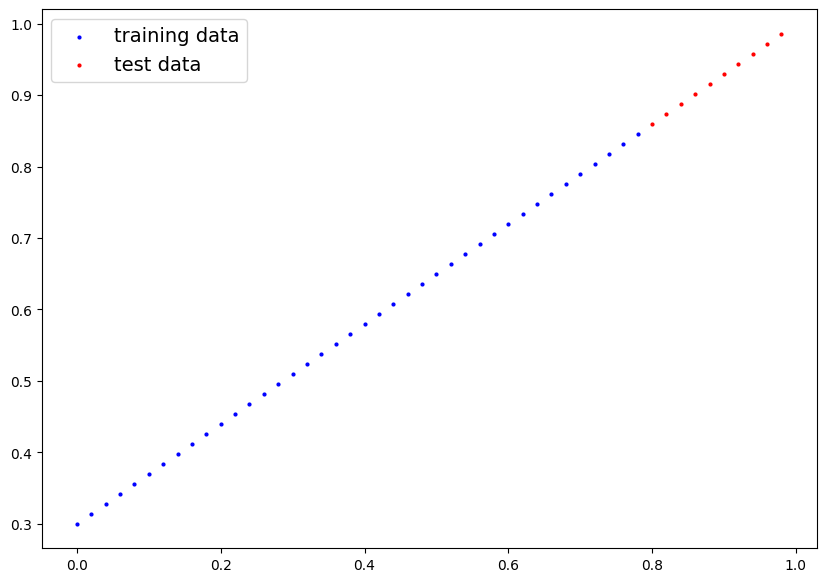

In [7]:
plot()

## Build Model

### Using class !

In [8]:
# Create linear regression module
# Almost everything in pytorch inherits from nn.Module # We imported nn from torch
# About super init: super().__init__() allows us to use other functions from another class (in this case: nn.Module)
# torch.randn(1) returns a single number. Remember, torch.randn(2,3) = 2x3 matrix, so 1 just means 1 number. torch.randn(3) means 3 numbers

class LinearRegressionModel(nn.Module):
    def __init__(self):  
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        
        # Define a forward pass, this case, linear regression
        # x: torch.Tensor is just a annotation(no diff in running) that x is this. Also, -> is annotation, indicating the type of output
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias 


## Pytorch Essentials

* torch.nn - contains all the building blocks
* torch.nn.Parameter 
* torch.nn.Module
* torch.optim
* def forward()
* torch.utils.data.Dataset  # Get used to this! torch.utils.data.DataLoader
* torch.utils.data.DataLoader

In [9]:
torch.manual_seed(42) # Reproducibility, fixes randomness into seed 42

model0 = LinearRegressionModel()  # We can call our model like this
list(model0.parameters()) # This would give us parameters, we can see them in a list form

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# Make predictions with model

with torch.inference_mode():
    y_pred = model0(X_test)

y_pred

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [11]:
y_test, y_test.dtype

(tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]),
 torch.float32)

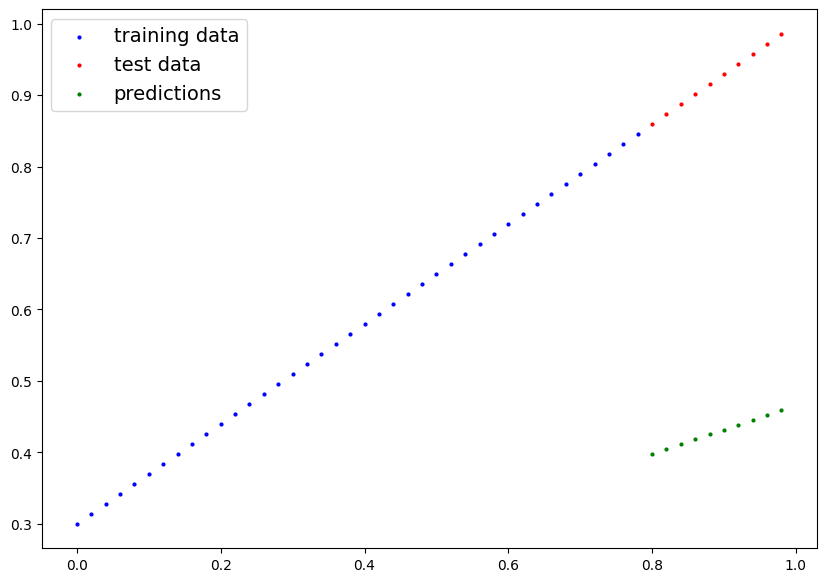

In [12]:
plot(prediction=y_pred)

## Loss function and Optimizer

In [13]:
# Of course, we need an optimizer and a loss function.

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(params= model0.parameters(), lr = 0.01)  # We use SGD optimizer, set the params, learning rate

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"y_pred shape: {y_pred.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([40, 1])
y_pred shape: torch.Size([10, 1])
y_train shape: torch.Size([40, 1])


## We need a Training Loop

In [16]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_function(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_function(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss} | MSE Test Loss: {test_loss} ")

Epoch: 0 | MSE Train Loss: 0.003750210627913475 | MSE Test Loss: 0.021257279440760612 
Epoch: 10 | MSE Train Loss: 0.0033502678852528334 | MSE Test Loss: 0.018905792385339737 
Epoch: 20 | MSE Train Loss: 0.003081799950450659 | MSE Test Loss: 0.017090920358896255 
Epoch: 30 | MSE Train Loss: 0.0028959002811461687 | MSE Test Loss: 0.015670273452997208 
Epoch: 40 | MSE Train Loss: 0.002761972602456808 | MSE Test Loss: 0.014542418532073498 
Epoch: 50 | MSE Train Loss: 0.0026608731132000685 | MSE Test Loss: 0.013634162954986095 
Epoch: 60 | MSE Train Loss: 0.0025806257035583258 | MSE Test Loss: 0.012892169877886772 
Epoch: 70 | MSE Train Loss: 0.0025137290358543396 | MSE Test Loss: 0.012277057394385338 
Epoch: 80 | MSE Train Loss: 0.0024554883129894733 | MSE Test Loss: 0.011759518645703793 
Epoch: 90 | MSE Train Loss: 0.00240295915864408 | MSE Test Loss: 0.011317544616758823 


In [20]:
## What we learned:

print(model0.state_dict())
print(f"weights are : {model0.weights}, bias is : {model0.bias}")

# Original setting was:
print(f"weights were: {w}, bias was : {b}")

OrderedDict([('weights', tensor([0.4899])), ('bias', tensor([0.3830]))])
weights are : Parameter containing:
tensor([0.4899], requires_grad=True), bias is : Parameter containing:
tensor([0.3830], requires_grad=True)
weights were: 0.7, bias was : 0.3


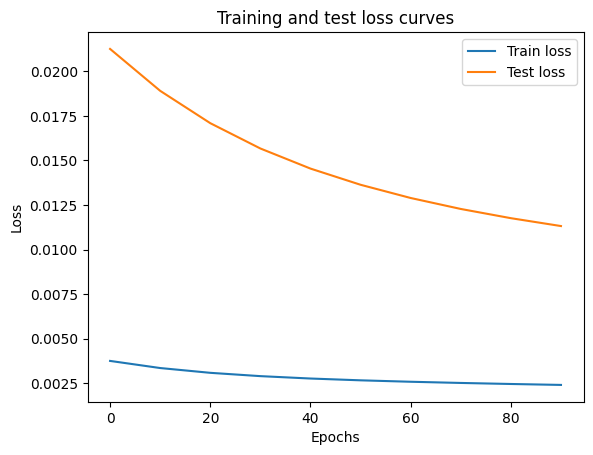

In [21]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## Making Predictions with a trained pytorch model

In [22]:
model0.eval()

with torch.inference_mode():
    y_pred = model0(X_test)
y_pred

tensor([[0.7749],
        [0.7847],
        [0.7945],
        [0.8043],
        [0.8141],
        [0.8239],
        [0.8337],
        [0.8435],
        [0.8532],
        [0.8630]])

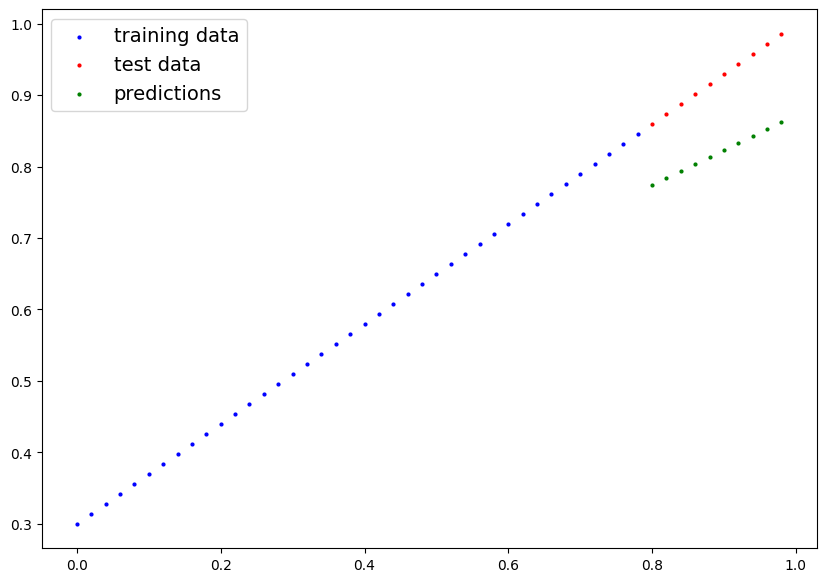

In [24]:
plot(prediction=y_pred)

## Saving and Loading a Pytorch Model

### How can we do this?

* torch.save : Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

* torch.load : Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

* torch.nn.Module.load_state_dict : Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [26]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "chapter01_pytorch_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/chapter01_pytorch_model.pth


In [27]:
# Check the saved file path
!ls -l models/chapter01_pytorch_model.pth

-rw-r--r--@ 1 shinyjay  staff  1656 Oct  7 08:47 models/chapter01_pytorch_model.pth


## Loading our model

In [28]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

/var/folders/j2/bs26lyw51kq5vvb8gr82czpm0000gn/T/ipykernel_30290/4060523491.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model0.load_state_dict(torch.load(f=MO

<All keys matched successfully>

In [29]:
# 1. Put the loaded model into evaluation mode
loaded_model0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model0(X_test) # perform a forward pass on the test data with the loaded model

In [31]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])